# Object detection for EdegeTPU : object detection for Reachy tictactoe 2021

This notebook allow you to use your own training network (with Tensorflow 1) for TPU. 

#### This notebook it's inspired by this code : https://github.com/google-coral/pycoral/blob/master/examples/detect_image.pyavec which run after the installation of *tflite_runtime* and *pycoral* API.  

In [38]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook 
import cv2 
from PIL import Image 

import time

from pycoral.adapters import classify, common
#from pycoral.utils.edgetpu import make_interpreter
#from pycoral.utils.dataset import read_label_file

from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate

from reachy_sdk import ReachySDK

from reachy_sdk.trajectory import goto
from reachy_sdk.trajectory.interpolation import InterpolationMode

#import argparse

from PIL import ImageDraw

from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

In [2]:
reachy = ReachySDK('localhost')

Fonction qui permet de dessiner les boxes sur les images : 

In [3]:
def draw_objects(draw, objs, labels):
#Draws the bounding box and label for each object.
  for obj in objs:
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline='red')
    draw.text((bbox.xmin + 10, bbox.ymin + 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill='red')


In [4]:
nb=600

In [4]:
#reachy.right_camera.start_autofocus

Pour tester la détection des cube, cylindres et cases vides ont peut lancer un code sur une image : 

In [69]:
path_model = '/home/reachy/Reachy_Nautilus/Retrain/tflite39927/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/Reachy_Nautilus/Retrain/tflite39927/label.txt'

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
time.sleep(1.5)
reachy.head.look_at(x=0.7, y=0, z=-0.6, duration=1) 
time.sleep(1.5)

image = reachy.right_camera.wait_for_new_frame()

time.sleep(1.5)
image = Image.fromarray(image)
top = 270
left = 40
height = 320
width = 320

box=(left, top, left+width, top+height)
 
image = image.crop(box) 
image = image.resize((300,300), Image.ANTIALIAS)
_, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

args_threshold = 0.4


start = time.perf_counter()
interpreter.invoke()
inference_time = time.perf_counter() - start
objs = detect.get_objects(interpreter, args_threshold, scale)
#print(objs)
#print('%.2f ms' % (inference_time * 1000))

#print('-------RESULTS--------')
#if not objs:
    #print('No objects detected')

#for obj in objs:
    #obj = objs[0]
    #print(labels.get(obj.id, obj.id))
    #print('  id:    ', obj.id)
    #print('  score: ', obj.score)
    #print('  bbox:  ', obj.bbox)

#image = image.convert('RGB')
draw_objects(ImageDraw.Draw(image), objs, labels)
image.save(f'/home/reachy/Reachy_Nautilus/images/img_test_detect/image{nb}.png')
nb = nb+1
image.show()

reachy.head.look_at(x=1.5, y=0, z=0, duration=1.5) 
time.sleep(1.5)


In [7]:
reachy.turn_off('reachy')

Pour tester la detection de facons plus intéractive on peut lancer la détection sur une vidéo est bouger les pions pendant que le programme tourne : 

In [ ]:
im = reachy.right_camera.wait_for_new_frame()
height, width = np.shape(im)[:2]

In [ ]:
video = cv.VideoWriter('tuto_classification400.avi',cv.VideoWriter_fourcc('M','J','P','G'), 5,(width,height))

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
time.sleep(1.5)

reachy.head.look_at(x=0.75, y=0, z=-0.4, duration=1.5) 
path_model = '/home/reachy/Desktop/tflite/form_detection1/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/Desktop/tflite/form_detection1/label.txt'

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

start = time.time()
fps_count = 0
nb = 1
while time.time() - start < 15:
    
    print(f'temps : {time.time() - start}')
    im = reachy.right_camera.wait_for_new_frame()
    out = im.copy()

    for row in range(3):
        for col in range(3):
            lx, rx, ly, ry = board_cases[row, col]
            
            image = Image.fromarray(out[ly:ry, lx:rx])
            image.save(f'/home/reachy/Desktop/image{nb}.png')
            nb = nb+1
            _, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

            args_count = 1
            args_threshold = 0.5

            for _ in range(args_count):
                start2 = time.perf_counter()
                interpreter.invoke()
                inference_time = time.perf_counter() - start2
                objs = detect.get_objects(interpreter, args_threshold, scale)
                print('%.2f ms' % (inference_time * 1000))

            print('-------RESULTS--------')
            if not objs:
                print('No objects detected')

            #for obj in objs:
            obj = objs[0]
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)
            label = 'pouet'
            if (obj.id == 0):
                label = 'empty'
            if (obj.id == 1):
                label = 'cube'
            if (obj.id == 2):
                label = 'cylinder'

            #image = image.convert('RGB')
            #draw_objects(ImageDraw.Draw(image), objs, labels)
            #image.save('image.png')
            #image.show()
            
            #label = labels.get(result[0].id)
            cv.putText(out, label, (int((lx+rx)/2)-30, int((ly+ry)/2)), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 2)
            cv.rectangle(out, (lx, ly), (rx, ry), (0, 255, 0), 5)
            #time.sleep(5)
    video.write(out)        
            
video.release()

reachy.head.look_at(0.5, 0, 0, duration=1)
time.sleep(0.2)

In [ ]:
video = cv.VideoWriter('tuto_classification400.avi',cv.VideoWriter_fourcc('M','J','P','G'), 10,(width,height))

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
time.sleep(1.5)

reachy.head.look_at(x=0.75, y=0, z=-0.6, duration=1.5) 
time.sleep(1.5)

path_model = '/home/reachy/Desktop/tflite2/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/Desktop/tflite2/label.txt'

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

start = time.time()
fps_count = 0

while time.time() - start < 15:
    
    image = reachy.right_camera.wait_for_new_frame()
    out = image.copy()
    
    image = Image.fromarray(image)
    #out = Image.fromarray(out)
    _, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

    args_count = 1
    args_threshold = 0.5

    for _ in range(args_count):
        start2 = time.perf_counter()
        interpreter.invoke()
        inference_time = time.perf_counter() - start2
        objs = detect.get_objects(interpreter, args_threshold, scale)
        print('%.2f ms' % (inference_time * 1000))

    print('-------RESULTS--------')
    if not objs:
        print('No objects detected')

    for obj in objs:
    #obj = objs[0]
        print(labels.get(obj.id, obj.id))
        print('  id:    ', obj.id)
        print('  score: ', obj.score)
        print('  bbox:  ', obj.bbox)

    #out = out.convert('RGB')
    #raw_objects(ImageDraw.Draw(out), objs, labels)
    #image.save('image.png')
    #image.show()
    cv.putText(out, label, (int((lx+rx)/2)-30, int((ly+ry)/2)), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 2)
    cv.rectangle(out, (lx, ly), (rx, ry), (0, 255, 0), 5)
    video.write(out)                    
video.release()

reachy.head.look_at(1, 0, 0, duration=1)
reachy.turn_off('head')

Pour générer des images pour l'entrainement : 

In [79]:
nb=8

In [61]:
# Get an image and check if the board is in the image

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  

time.sleep(1.0)

reachy.head.look_at(x=0.65, y=0, z=-0.6, duration=1.5) 
#you can adjust the z parameter to get the board in the image

#_, img = reachy.head.right_camera.read()
img = reachy.right_camera.wait_for_new_frame()
time.sleep(2.0)

reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
print(type(img))

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


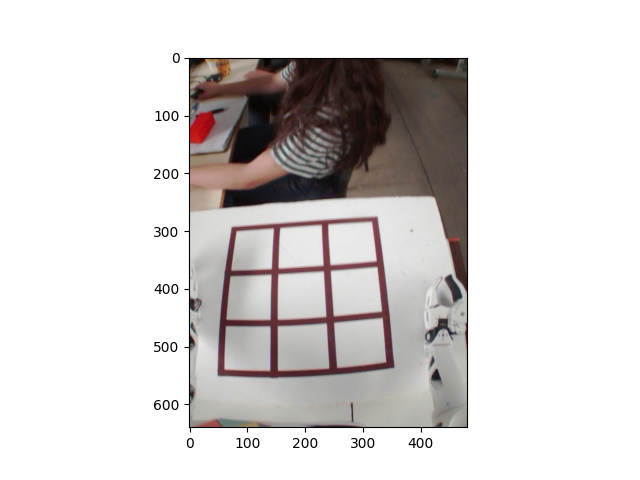

In [62]:
# Visualize what Reachy saw, adjust z parameter in the look_at until you see the whole board.

plt.figure()
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#dst = cv2.cvtColor(src, code)

In [59]:
#top = 290
#left = 40
#height = 320
#width = 320
y1 = 290
y2 = 600
x1 = 10
x2 = 380
dim = (300,300)

img = img[y1:y2, x1:x2]
img = cv2.resize(img, dim)
#img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#box=(left, top, left+width, top+height)
#img = Image.fromarray(img)

#img = img.crop(box) 
#img = img.resize((300,300), Image.ANTIALIAS)

#img = img.convert('RGB')
cv.imwrite(f'/home/reachy/Reachy_Nautilus/Retrain/Data/image{nb}.png', img)
#img.save(f'/home/reachy/Reachy_Nautilus/Retrain/Data/image{nb}.png')
nb = nb+1

error: OpenCV(4.5.2) /home/reachy/opencv-4.5.2/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [60]:
reachy.turn_off('reachy')

In [33]:
img = Image.open("/home/reachy/Reachy_Nautilus/Notebook/img_test_detect/image113.png") 

top = 210
left = 10
height = 400
width = 400

box=(left, top, left+width, top+height)
 
img_res = img.crop(box) 

img_res.save('/home/reachy/Reachy_Nautilus/Notebook/img_test_detect/pouet.png')
img_res.show() 